In [60]:
import networkx as nx
import matplotlib.pyplot as plt
from queue import Queue
import sys
from dataclasses import dataclass

## Utils functions

In [61]:
def draw_with_colors(graph, highlight_nodes = [], even_more_nodes = []):
    node_colors = ['red' if node in highlight_nodes else 'green' if node in even_more_nodes else 'blue' for node in graph.nodes()]
    nx.draw(graph, with_labels=True, font_weight='bold', node_color=node_colors)
    plt.show()

def print_graph_representation(g):
    print("{")
    for node in g.nodes():
        neighbors = list(g.neighbors(node))
        print(f"{node}: {neighbors},")
    print("}")
    
def dict_to_nx_graph(graph_dict):
    return nx.from_dict_of_lists(graph_dict, create_using=nx.DiGraph)

def get_random_graph_with_starting_vertices(n=3, p=0.3, n_starting_vertices=2, n_final_vertices=2, seed=None):
    g = nx.gnp_random_graph(n, p, directed=True, seed=seed)
    nodes = list(g.nodes())
    starting_vertices = nodes[:n_starting_vertices].copy()
    final_vertices = nodes[n_starting_vertices:(n_starting_vertices + n_final_vertices)].copy()
    return g, starting_vertices, final_vertices

## Algorithm 

### idea #1

#### BFS part of the algorithm

In [62]:
def unoptimized_build_parent_graph(graph, starting_nodes, _final_vertices):
    visited = {s_i: [] for s_i in starting_nodes}
    open = Queue()
    for s in starting_nodes:
        open.put(s)

    while not open.empty():
        current_node = open.get()
        for n in graph.neighbors(current_node):
            if n not in visited:
                visited[n] = [current_node]
                open.put(n)
            else:
                parents = visited[n].copy()
                parents.append(current_node)
                visited[n] = parents
    return visited


def optimized_build_parent_graph(graph, starting_nodes, _final_vertices):
    visited = {s_i: (set(), {s_i}) for s_i in starting_nodes}
    open = Queue()
    for s in starting_nodes:
        open.put(s)
    
    while not open.empty():
        current_node = open.get()
        parents_curr, starting_vertices_curr = visited[current_node]
        for n in graph.neighbors(current_node):
            if n not in visited:
                visited[n] = ({current_node}, starting_vertices_curr.copy())
                open.put(n)
            else:
                parents_n, starting_vertices_n = visited[n]
                dif = starting_vertices_curr - starting_vertices_n
                if len(dif) > 0:
                    visited[n] = (parents_n | {current_node}) - {n} , starting_vertices_n | starting_vertices_curr
                    p, _ = visited[n]
                    if n in p:
                        print(f"Curr = {current_node}")
                        print(f"n = {n}")
                        print(visited)
                        print(open)
    transformed_visited = {n: parents for n, (parents, _) in visited.items()}
    return transformed_visited

#### Extracting paths

In [63]:
def _extract_path_helper(node, curr_path, parent_graph, processed, starting_vertices):
    # TODO is not true, a starting vertex A can also be reached from other starting vertex B.
    if node in starting_vertices:
        return {node: [node]}
    ret = {}
    curr_path.add(node)
    for parent in parent_graph.neighbors(node):
        reachable_from_parent = set()
        if parent in processed:
            reachable_from_parent = processed[parent]
        elif parent not in curr_path:
            reachable_from_parent = _extract_path_helper(parent, curr_path.copy(), parent_graph, processed, starting_vertices)
        for starting_node, path in reachable_from_parent.items():
            path_with_current_node = path.copy()
            path_with_current_node.append(node)
            ret[starting_node] = path_with_current_node
    processed[node] = ret
    return ret

# TODO Think about how to fix this so that the path reconstruction will allow for 
# reconstruction of paths from ALL starting vertices
def _extract_path_helper_2(node, curr_path, parent_graph, processed, starting_vertices):
    # maybe this if should be
    # if parent_graph[node] == []:
    #    return {node: [node]}
    if node in starting_vertices:
        return {node: [node]}
    ret = {}
    curr_path.add(node)
    for parent in parent_graph.neighbors(node):
        reachable_from_parent = set()
        if parent in processed:
            reachable_from_parent = processed[parent]
        elif parent not in curr_path:
            reachable_from_parent = _extract_path_helper(parent, curr_path.copy(), parent_graph, processed, starting_vertices)
        for starting_node, path in reachable_from_parent.items():
            path_with_current_node = path.copy()
            path_with_current_node.append(node)
            ret[starting_node] = path_with_current_node
    processed[node] = ret
    return ret



def extract_path(parent_graph, starting_vertices, final_vertices):
    processed = dict()
    for f in final_vertices:
        _extract_path_helper(f, set(), parent_graph, processed, starting_vertices)
    return processed

#### Full flow

In [64]:
def find_paths(graph, starting_vertices, final_vertices):
    parent_graph_dict = optimized_build_parent_graph(graph, starting_vertices, final_vertices)
    parent_graph = dict_to_nx_graph(parent_graph_dict)
    ret = extract_path(parent_graph, starting_vertices, final_vertices)
    return ret

### The more the merrier impl

#### class Path

In [82]:
class Path:
    def __init__(self):
        """
        Initializes an empty path.
        """
        self.nodes = []

    def add_element(self, node):
        """
        Adds a node to the end of the path.

        :param node: The node to add to the path.
        """
        self.nodes.append(node)

    def __repr__(self):
        """
        Returns a string representation of the path.
        """
        return f"Path({self.nodes})"

    def __len__(self):
        """
        Returns the number of nodes in the path.
        """
        return len(self.nodes)

    # def __getitem__(self, index):
    #     """
    #     Returns the node at the specified index.
    #     """
    #     return self.nodes[index]

    
    def __hash__(self):
        """
        Returns a hash of the Path object, making it usable in sets or as dict keys.
        """
        return hash(tuple(self.nodes))


In [88]:
from collections import defaultdict

# def merge_all_paths_in_paths_struct(paths_struct_1, paths_struct_2):
#     ret = {}
#     for k in paths_struct_1:
#         ret[k] = paths_struct_1[k]
#         ret[k] |= paths_struct_2.get(k, {})
#     for k in paths_struct_2:
#         if k not in ret:
#             ret[k] = paths_struct_2[k]
#     return ret

def the_more_the_merrier_extract_paths_helper(seen, bfs_to_extract, node):
    if node == bfs_to_extract:
        p = Path()
        p.add_element(node)
        return {p}
    else:
        ret = set()
        parents = seen[node].get(bfs_to_extract, {})
        for parent in parents:
            ret_paths_for_parent = the_more_the_merrier_extract_paths_helper(seen, bfs_to_extract, parent)
            ret_to_add = set()
            for path_to_reach_parent in list(ret_paths_for_parent):
                ret_paths_for_parent.remove(path_to_reach_parent)
                path_to_reach_parent.add_element(node)
                ret_to_add.add(path_to_reach_parent)
            ret |= ret_to_add
        return ret

def the_more_the_merrier_extract_paths(seen, node, direct_parent, set_of_bfses_to_extract):
    for b in set_of_bfses_to_extract:
        assert direct_parent in seen[node][b]
        ret_b = the_more_the_merrier_extract_paths_helper(seen, b, direct_parent)
        for path_b in list(ret_b):
            ret_b.remove(path_b)
            path_b.add_element(node)
            print(f"got path {path_b}")

def the_more_the_merrier(graph, starting_nodes, _final_vertices):     
    def change_visit_list_to_visit_dict(visit_list):
        res = {}
        for (k, s) in visit_list:
            if k not in res:
                res[k] = s
            else:
                res[k] |= s
        return res
    visit = [(s_i, {s_i}) for s_i in starting_nodes]
    visit_next = []
    seen = defaultdict(dict)
    for s in starting_nodes:
        seen[s][s] = {}
    while visit:
        visit_dict = change_visit_list_to_visit_dict(visit)
        for v in visit_dict:
            for n in graph.neighbors(v):
                D = visit_dict[v] - set(seen[n].keys())
                if len(D) > 0:
                    visit_next.append((n, D))
                    for d_bfs in D:
                        seen[n][d_bfs] = {v}
                    if n in _final_vertices:
                        the_more_the_merrier_extract_paths(seen, n, v, D)
        visit = visit_next
        visit_next = []


# def the_more_the_merrier_all_shortest_path(graph, starting_nodes, _final_vertices):     
#     def change_visit_list_to_visit_dict(visit_list):
#         res = {}
#         for (k, s) in visit_list:
#             if k not in res:
#                 res[k] = s
#             else:
#                 res[k] |= s
#         return res
    
#     visit = [(s_i, {s_i}) for s_i in starting_nodes]
#     visit_next = []
#     seen = defaultdict({})
#     for s in starting_nodes:
#         seen[s][s] = {}
#     while visit:
#         visit_dict = change_visit_list_to_visit_dict(visit)
#         seen_to_add = []
#         for v in visit_dict:
#             for n in graph.neighbors(v):
#                 D = visit_dict[v] - set(seen[n].keys())
#                 if len(D) > 0:
#                     visit_next.append((n, D))
#                     for d_bfs in D:
#                         # seen[n][d_bfs] = {v}
#                         seen_to_add.append((n, d_bfs, v))
#         for (node, bfs_node, parent) in seen_to_add:
#             if bfs_node not in seen[n]:
#                 seen[n][bfs_node] = {parent}
#             else:
#                 seen[n][bfs_node] |= {parent}
        
#         visit = visit_next
#         visit_next = []
         
            

In [ ]:
def roboczy_optimized_build_parent_graph(graph, starting_nodes, _final_vertices):
    visited = {s_i: {s_i: set()}} for s_i in starting_nodes}
    to_visit = Queue()
    for s in starting_nodes:
        open.put(s)
    
    while not to_visit.empty():
        current_node = open.get()
        bfses_curr = visited[current_node]
        for n in graph.neighbors(current_node):
            if n not in visited:
                visited[n] = ({current_node}, starting_vertices_curr.copy())
                open.put(n)
            else:
                bfses_n = visited[n]
                dif = set(bfses_curr.keys()) - set(dict
                if len(dif) > 0:
                    visited[n] = (parents_n | {current_node}) - {n} , starting_vertices_n | starting_vertices_curr
                    p, _ = visited[n]
                    if n in p:
                        print(f"Curr = {current_node}")
                        print(f"n = {n}")
                        print(visited)
                        print(open)
    transformed_visited = {n: parents for n, (parents, _) in visited.items()}
    return transformed_visited

## Simulation

In [21]:

def handle_graph_unoptimized(graph, starting_nodes, final_vertices):
    bfs_g = unoptimized_build_parent_graph(graph, starting_nodes, final_vertices)
    nx_bfs_g = dict_to_nx_graph(bfs_g)
    cycles = list(nx.simple_cycles(nx_bfs_g))
    if len(cycles) > 0:
        print("########## cycles detected #####################")
        print("original graph")
        draw_with_colors(graph, starting_nodes)
        print("bfs graph")
        draw_with_colors(nx_bfs_g, starting_nodes)
        for cycle in cycles:
            print(cycle)
        return False
    else:
        return True

def handle_graph_optimized(graph, starting_nodes, final_vertices):
    bfs_g = optimized_build_parent_graph(graph, starting_nodes, final_vertices)
    nx_bfs_g = dict_to_nx_graph(bfs_g)
    cycles = list(nx.simple_cycles(nx_bfs_g))
    if len(cycles) > 0:
        print("########## cycles detected #####################")
        print("original graph")
        print_graph_representation(graph)
        draw_with_colors(graph, starting_nodes)
        print("bfs graph")
        print_graph_representation(nx_bfs_g)
        draw_with_colors(nx_bfs_g, starting_nodes)
        for cycle in cycles:
            print(cycle)
        return False
    else:
        return True
        


def simulate(n_simulations=100, initial_seed=45):
    seed = initial_seed
    for i in range(n_simulations):
        g, starting, final = get_random_graph_with_starting_vertices(seed=seed)
        if not handle_graph_optimized(g, starting, final):
            print("Simulation end")
            return
        print("#################################")
        seed += 1
    print("Simulation end")

########## cycles detected #####################
original graph
{
0: [1],
1: [0],
2: [0, 1],
}


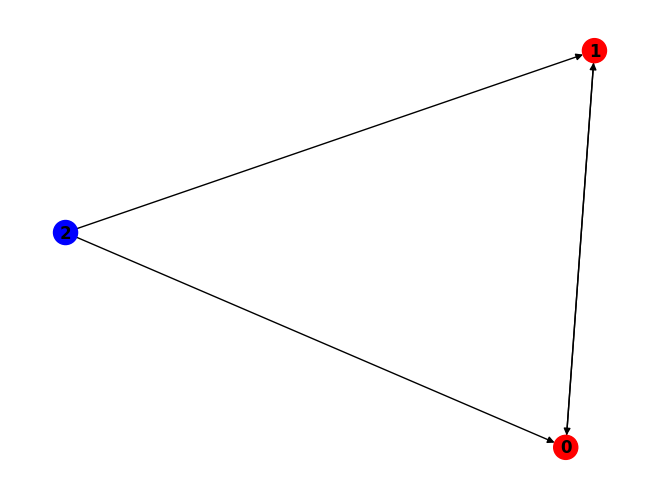

bfs graph
{
0: [1],
1: [0],
}


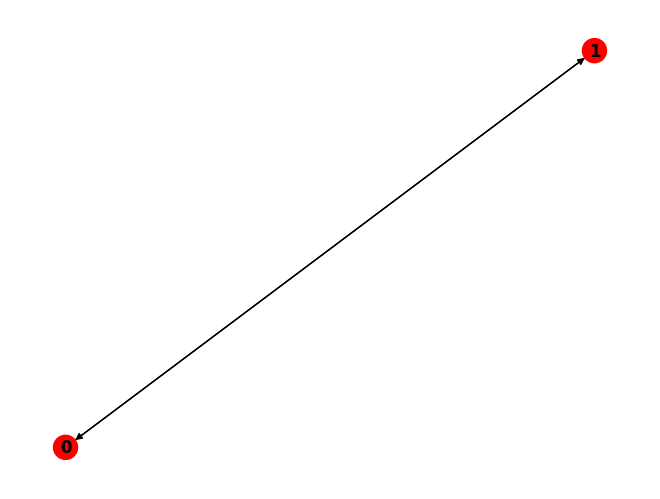

[0, 1]
Simulation end


In [22]:
simulate()

## Examples


In [23]:
@dataclass
class Example:
    graph: nx.Graph
    starting_vertices: [int]
    final_vertices: [int]

def create_example(graph_dict, sv, fv):
    return Example(dict_to_nx_graph(graph_dict), sv, fv)

In [66]:
def handle_example(e):
    draw_with_colors(e.graph, e.starting_vertices, e.final_vertices)
    the_more_the_merrier(e.graph, e.starting_vertices, e.final_vertices)
    # bfs_g = optimized_build_parent_graph(e.graph, e.starting_vertices, e.final_vertices)
    # nx_bfs_g = dict_to_nx_graph(bfs_g)
    # cycles = list(nx.simple_cycles(nx_bfs_g))
    # print_graph_representation(nx_bfs_g)
    # draw_with_colors(nx_bfs_g, e.starting_vertices)    
    # if len(cycles) > 0:
    #     print("CYCLES DETECTED")
    #     for cycle in cycles:
    #         print(cycle)

def run_full_flow(e):
    print(e)
    draw_with_colors(e.graph, e.starting_vertices, e.final_vertices)
    paths = find_paths(e.graph, e.starting_vertices, e.final_vertices)
    print(paths)

### Custom examples

#### e path

In [89]:
e_path = create_example({1: [0], 0: [2]}, [0, 1], [2])

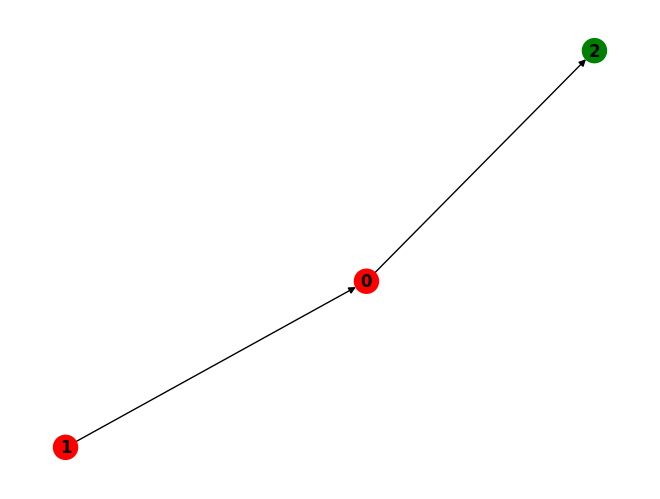

got path Path([0, 2])
got path Path([1, 0, 2])


In [90]:
handle_example(e_path)

#### e cycle with two finals

In [91]:
e_cycle_with_two_finals = create_example({0: [1, 2], 1: [0, 3]}, [0, 1], [2, 3])

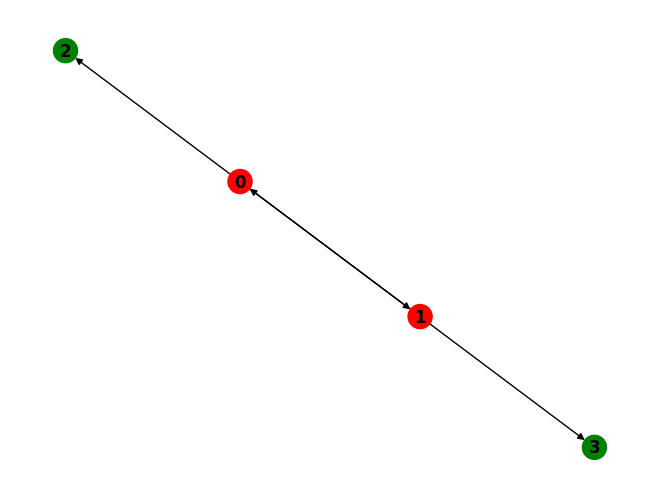

got path Path([0, 2])
got path Path([1, 3])
got path Path([0, 1, 3])
got path Path([1, 0, 2])


In [92]:
handle_example(e_cycle_with_two_finals)

#### E triangle

In [93]:
e_triangle = create_example({0: [2],
1: [0],
2: [1]}, [0, 1], [2])

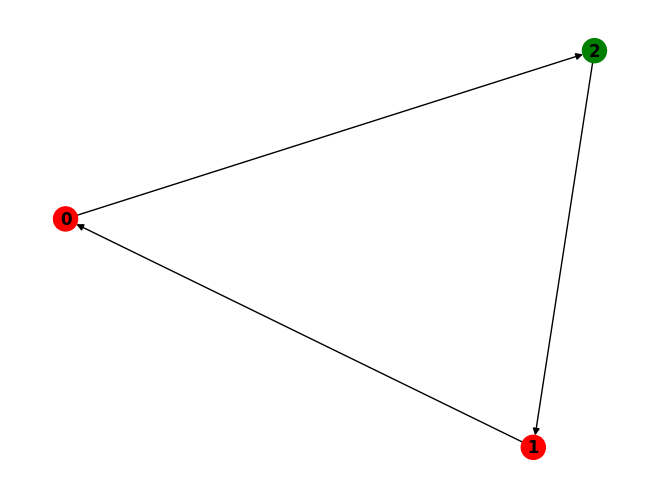

got path Path([0, 2])
got path Path([1, 0, 2])


In [94]:
handle_example(e_triangle) 

#### E triangle 2

For every vertex v i want to have a set of parents P such that if there exists a path from starting vertex s to v then u \in P will be a direct parent in this path.

0 1

1 -> 0 1 \in P_0
0 -> 1 0 \in P_1

In [95]:
e_triangle_2 = create_example({0: [1],
1: [0],
2: [0, 1]}, [0, 1], [2])

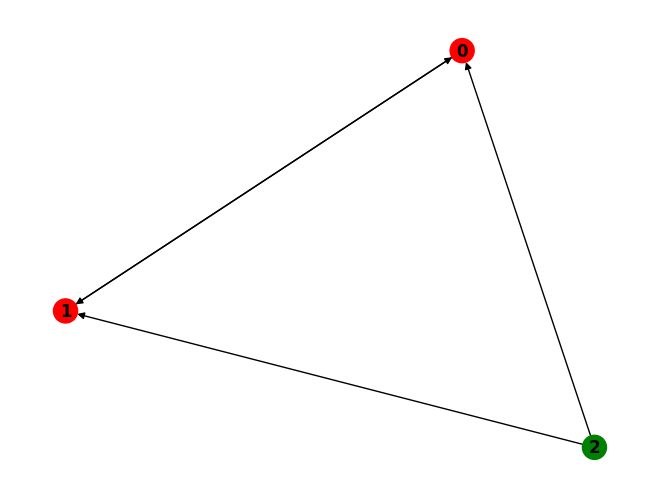

In [96]:
handle_example(e_triangle_2)

#### E from Evaluating regular path queries under the all-shortest paths semantics

In [97]:
e_paper_rpq_all_shortest_paths = create_example({
    0: [1, 2, 3],
    1: [4],
    2: [4],
    3: [4],
    4: [5]
}, [2, 3], [5])

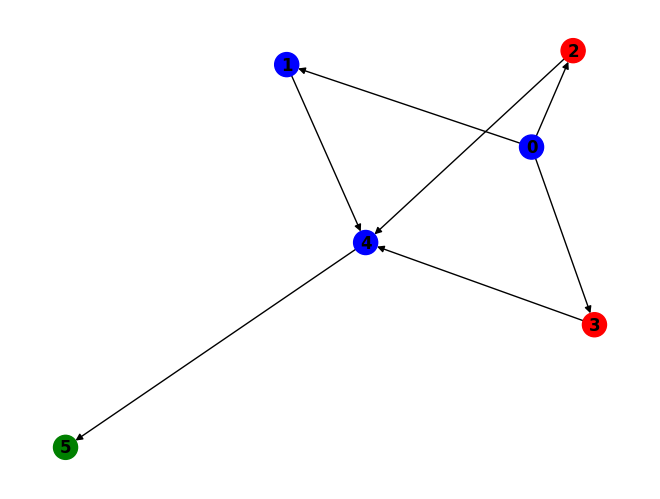

got path Path([2, 4, 5])
got path Path([3, 4, 5])


In [98]:
handle_example(e_paper_rpq_all_shortest_paths)

### Examples from the photo

In [44]:
e_1 = create_example({0: [2],
       1: [3],
       2: [4],
       3: [4],
       4: [5],
       5: [6]
}, [0, 1], [6])
e_2 = create_example({0: [2],
       1: [3],
       2: [4],
       3: [5],
       4: [6],
       5: [4, 7],
       6: [8],
       7: [9]
}, [0, 1], [8, 9])
e_3 = create_example({0: [2],
       1: [3],
       2: [4],
       3: [5],
       4: [6],
       5: [4, 8],
       6: [8],
}, [0, 1], [8])

Example(graph=<networkx.classes.digraph.DiGraph object at 0x10db12990>, starting_vertices=[0, 1], final_vertices=[8, 9])


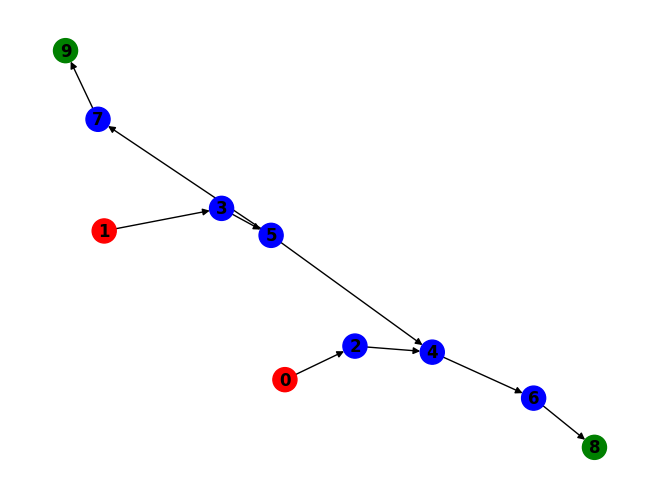

{2: {0: [0, 2]}, 3: {1: [1, 3]}, 5: {1: [1, 3, 5]}, 4: {0: [0, 2, 4], 1: [1, 3, 5, 4]}, 6: {0: [0, 2, 4, 6], 1: [1, 3, 5, 4, 6]}, 8: {0: [0, 2, 4, 6, 8], 1: [1, 3, 5, 4, 6, 8]}, 7: {1: [1, 3, 5, 7]}, 9: {1: [1, 3, 5, 7, 9]}}


In [45]:
run_full_flow(e_2)

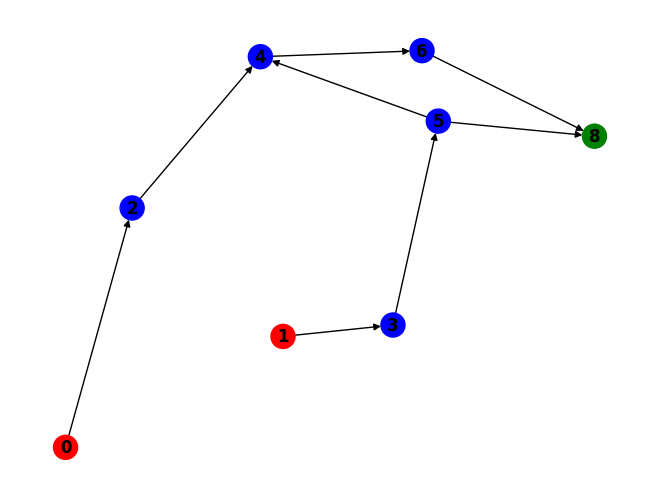

{
0: [],
1: [],
2: [0],
3: [1],
4: [2, 5],
5: [3],
6: [4],
8: [5, 6],
}


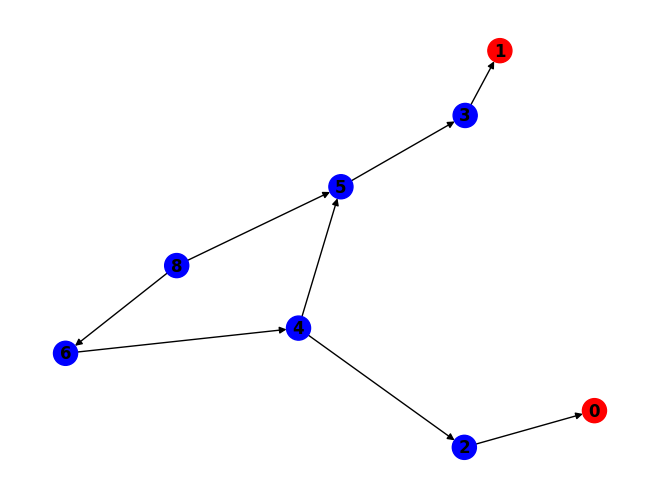

In [46]:
handle_example(e_3)